In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [10]:
import h5py as h5
import numpy as np
import pycuda.driver as cuda
import pycuda.gpuarray as ga

from chroma.event import Photons
import h5py as h5

f = h5.File("/sdf/data/neutrino/public_html/dc/mpvmpr_20.h5", "r", libver="latest", swmr=True)

INVALID_TRACK_ID = pow(2, 31) - 1
light_yield = 20000 # photons/MeV @ 500V/cm

def photons(f, wavelength=450):
    """
    note: wavelength doesn't matter as there are no wavelength-dependent effects
    during propagation in the liquid argon. however, there *are* in the glass of the PMTs,
    so we set the wavelength to a wavelength similar to that after being reemitted by TPB.
    """
    events_s_v = f['pstep/lar_vol']
    events_p_v = f['particle/geant4']
    for i in range(len(events_s_v)):
        event_s = events_s_v[i]
        event_p = events_p_v[i]
        mask = ~(event_s["track_id"] == INVALID_TRACK_ID)
        event_s = event_s[mask]

        # for computing beta*gamma
        # mass = event_p['mass'][event_s['track_id']]
        # mask = mass > 0
        # event_s = event_s[mask]
        # mass = mass[mask]

        de = event_s['de']
        t = event_s['t']
        t -= t.min()
        x, y, z = event_s['x'], event_s['y'], event_s['z']
        pos = np.column_stack([x, y, z])

        num_photons = np.ceil(de * light_yield).astype(np.int32)
        total_photons = np.sum(num_photons)

        # random direction
        costheta = np.random.random(total_photons) * 2 - 1
        sintheta = np.sqrt(1 - np.square(costheta))
        phi = np.random.random(total_photons) * 2 * np.pi
        cosphi = np.cos(phi)
        sinphi = np.sin(phi)
        pdir = np.transpose([sintheta * cosphi, sintheta * sinphi, costheta])

        # random polarization
        costheta = np.random.random(total_photons) * 2 - 1
        sintheta = np.sqrt(1 - np.square(costheta))
        phi = np.random.random(total_photons) * 2 * np.pi
        cosphi = np.cos(phi)
        sinphi = np.sin(phi)
        rand_unit = np.transpose([sintheta * cosphi, sintheta * sinphi, costheta])
        ppol = np.cross(pdir, rand_unit)
        ppol = ppol / np.linalg.norm(ppol, ord=2, axis=1, keepdims=True)

        if type(wavelength) is tuple:
            pwavelength = (
                np.random.random(total_photons) * (wavelength[1] - wavelength[0]) + wavelength[0]
            )
        else:
            pwavelength = np.tile(wavelength, total_photons)

        photons = Photons(
            pos=np.repeat(pos, num_photons, axis=0),
            dir=pdir,
            pol=ppol,
            t=np.repeat(t, num_photons),
            wavelengths=pwavelength,
            evidx=np.repeat(i, total_photons),
        )
        yield photons


num_photons = [(f['pstep/lar_vol'][i]['de']*light_yield).sum() for i in range(len(f['pstep/lar_vol']))]
num_photons

[18528768.0,
 156654200.0,
 154819740.0,
 55836772.0,
 185839600.0,
 154153660.0,
 135658200.0,
 97843944.0,
 53128124.0,
 132014480.0,
 178409970.0,
 234665250.0,
 196912220.0,
 165495200.0,
 154901840.0,
 201038110.0,
 216578430.0,
 124699110.0,
 180451780.0,
 60925984.0]

In [21]:
from chroma_lar.geometry import build_detector_from_config
from chroma.sim import Simulation
import time

cfg = dict(
    include_active=True,
    include_cavity=False,
    include_pmts=True,
    include_cathode=True,
    include_wires=True,
    analytic_wires=True,
)

g = build_detector_from_config("detector_config_reflect_reflect3wires", **cfg)

sim = Simulation(g, photon_tracking=0)

# generate a small test of photons near a wireplane

# run a short propagation to get rid of overhead
from chroma_lar.generator import photon_gen
phot = photon_gen(10)
_ = list(
    sim.simulate(
        phot,
        keep_photons_end=False,
        keep_hits=False,
        keep_flat_hits=False,
        photons_per_batch=10,
        max_steps=1000,
    )
)

t_total = 0
t_start = time.time()
p = next(photons(f))
for i, ev in enumerate(
    sim.simulate(
            p,
            keep_photons_end=False,
            keep_hits=False,
            keep_flat_hits=True,
            photons_per_batch=5_000_000,
            max_steps=1000,
        )
    ):
    print(f"event {i}/{len(f['pstep/lar_vol'])}")

    t = ev.flat_hits.t # ...

    t_end = time.time()
    t_total += t_end - t_start
    t_diff = t_end - t_start
    t_start = t_end
    phot_sec = num_photons[i] / t_diff
    print(f"time: {t_total:.2f} s, {phot_sec/1_000:,.0f}k ph/s, {num_photons[i]:,.0f} ph")
    break
print(f"total time: {t_total} seconds")


Total PMT number is 162
Spacing buffer in y: 320.0, z: 320.0
analytic wireplanes attached: 6 (total=6)
analytic wireplanes attached: 6


event 0/20
time: 15.33 s, 1,209k ph/s, 18,528,768 ph
total time: 15.329093217849731 seconds


In [12]:
ev.flat_hits.t.min(), ev.flat_hits.t.max()

(1.0356066, 604.50085)

In [15]:
dir(g)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_pdf_to_cdf',
 'add_pmt',
 'add_solid',
 'bvh',
 'channel_index_to_channel_type',
 'channel_index_to_position',
 'channel_index_to_solid_id',
 'charge_cdf',
 'colors',
 'detector_material',
 'flatten',
 'material1_index',
 'material2_index',
 'mesh',
 'num_channels',
 'set_charge_dist_gaussian',
 'set_time_dist',
 'set_time_dist_gaussian',
 'solid_displacements',
 'solid_id',
 'solid_id_to_channel_index',
 'solid_rotations',
 'solids',
 'surface_index',
 'time_cdf',
 'unique_materials',
 'unique_surfaces',
 'wireplanes']

In [16]:
g.num_channels()

162

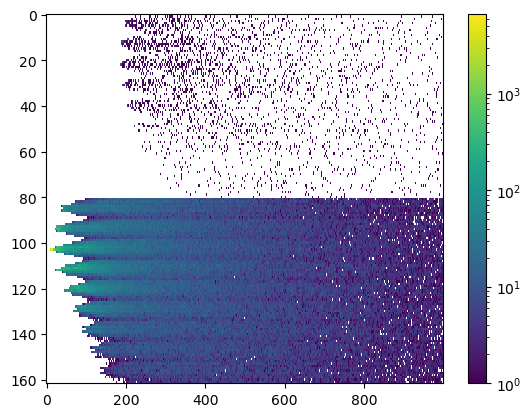

In [30]:
t = ev.flat_hits.t
channel = ev.flat_hits.channel
num_pmts = g.num_channels()
counts = np.histogram2d(
    channel,
    t,
    bins=(num_pmts, 1000),
    range=((0, num_pmts), (0, 100)),
)[0].flatten()


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.imshow(counts.reshape(num_pmts, 1000), norm=LogNorm(), aspect='auto', interpolation='none')
plt.colorbar()
plt.show()


In [ ]:
import plotly.graph_objects as go
import torch
from tqdm import tqdm


fig = go.Figure()

if g is not None:
    solids = g.solids
    for i, solid in enumerate(tqdm(solids)):
        colors = solid.color  # (N,) in hex (uint16)
        triangles = solid.mesh.triangles  # (N, 3)
        vertices = solid.mesh.vertices  # (M, 3), M<=N

        # Convert to PyTorch tensors on GPU
        vertices_torch = torch.tensor(vertices, device="cuda", dtype=torch.float32)
        try:
            pos = torch.tensor(g.solid_displacements[i], device="cuda", dtype=torch.float32)
            rot = torch.tensor(g.solid_rotations[i], device="cuda", dtype=torch.float32)
        except Exception:
            pos = None
            rot = None

        # Convert hex colors to RGB format for plotly
        rgb_colors = []
        for color in colors:
            # Extract RGB components from uint16 hex
            r = ((color >> 10) & 0x1F) / 31.0
            _g = ((color >> 5) & 0x1F) / 31.0
            b = (color & 0x1F) / 31.0
            rgb_colors.append(f"rgb({int(r * 255)},{int(_g * 255)},{int(b * 255)})")

        # Create mesh3d for each solid
        i_vertices = []
        j_vertices = []
        k_vertices = []

        for triangle in triangles:
            i_vertices.append(triangle[0])
            j_vertices.append(triangle[1])
            k_vertices.append(triangle[2])

        # Perform displacements using GPU
        if rot is not None:
            vertices_torch = torch.matmul(vertices_torch, -rot)
        if pos is not None:
            vertices_torch = vertices_torch + pos

        # Convert back to numpy for plotting
        vertices = vertices_torch.cpu().numpy()

        fig.add_trace(
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=i_vertices,
                j=j_vertices,
                k=k_vertices,
                facecolor=rgb_colors,
                opacity=0.1,
                name=f"Solid {i}",
            )
        )

pos = p.pos
t = p.t
# randomly sample 200k points from pos -- otherwise we crash
if len(pos) > 200000:
    indices = torch.randperm(len(pos))[:200000]
    pos = pos[indices]
    t = t[indices]
fig.add_trace(go.Scatter3d(x=pos[:, 0], y=pos[:, 1], z=pos[:, 2], mode='markers', marker=dict(size=1, color=t, colorbar=dict(title="Time"))))
fig.write_image("img/detector_visualization.png")
# fig.show()

100%|██████████| 164/164 [00:18<00:00,  8.97it/s]


![img/detector_visualization.png](img/detector_visualization.png)